# Capter 5: Discussion

This chapter analyses and interprets the results presented in the previous chapter, providing a deeper context and meaning. The last part explores current limitations and potential further research to guide future developments.


In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np

from configs import _models
from configs._scanners import get_miniPET_geometry

from generators.mixed import MixedDataset
from utils.data import load_miniPET_sino, load_miniPET_img
from utils.inits import init_pytorch
from utils.plots import plot_images
from utils.evaluate import evaluate_model
import pickle
from matplotlib import pyplot as plt
import numpy as np


              -  -  -  -  -  -  -  -   -  -  -  -
              P  A  R  A  L  L  E  L | P  R  O  J
              -  -  -  -  -  -  -  -   -  -  -  -


             Please consider citing our publication
          ---------------------------------------------
          Georg Schramm and Kris Thielemans:
          "PARALLELPROJ—an open-source framework for
           fast calculation of projections in
           tomography"
          Front. Nucl. Med., 08 January 2024
          Sec. PET and SPECT, Vol 3
          https://doi.org/10.3389/fnume.2023.1324562

 
        parallelproj C    lib         ..: /opt/conda/envs/smn/lib/libparallelproj_c.so.1.10.0
        parallelproj CUDA lib         ..: /opt/conda/envs/smn/lib/libparallelproj_cuda.so.1.10.0
        parallelproj CUDA kernel file ..: /opt/conda/envs/smn/lib/projector_kernels.cu.1.10.0
        parallelproj CUDA present     ..: True
        parallelproj cupy enabled     ..: True
        


## Synthetic Training Data

To minimise these types of artefacts while preserving the strengths of both reconstructions, a mixed dataset of random ellipsoids and random shapes was used.

In [2]:
# Initialize the device
device: torch.device = init_pytorch()

# Set volume dimensions
IMG_WIDTH: int = 147
IMG_HEIGHT: int = 147
IMG_DEPTH: int = 35

Using CUDA with 1 GPU(s)...


In [3]:
# Set the noise level
NOISE_LEVEL: float = 0.5

In [4]:
# Create the miniPET geometry
miniPET_geometry = get_miniPET_geometry(
    device=device, img_width=IMG_WIDTH, img_height=IMG_HEIGHT, num_rings=IMG_DEPTH
)

In [5]:
BATCH_SIZE: int = 6
TRAIN_SAMPLES: int = 500

In [6]:
synthetic_dataset = MixedDataset(
    device,
    projector=miniPET_geometry.proj,
    n_imgs=TRAIN_SAMPLES,
    n_labels=6,
    noise_interval=(0.1, 1.2),
    kernel_size=5,
    sigma=2.0,
    modality="shapes",
)

data_loader = DataLoader(synthetic_dataset, batch_size=1, shuffle=True)

# Get the first batch of the data loader
data_loader_iter = iter(data_loader)
sinogram_shapes, image_shapes, label_shapes, map_shapes = next(data_loader_iter)

In [7]:
FILE_SINO_PATH: str = "data/sino40min.sino.mnc"
FILE_IMG_PATH: str = "data/GT.mnc"
sinogram_mouse = load_miniPET_sino(device, FILE_SINO_PATH)
image_mouse = load_miniPET_img(device, FILE_IMG_PATH)

In [8]:
NUM_LPD_ITERATIONS: int = 3
SLICE_TO_PLOT: int = 17

shapes_slice: torch.Tensor = image_shapes.squeeze()[:, SLICE_TO_PLOT, :]

mouse_slice: torch.Tensor = image_mouse[:, SLICE_TO_PLOT, :]

In [9]:
# Initialise the full model
model = _models.get_LPD_Unet2D_model(
    device,
    projector=miniPET_geometry.proj,
    n_iter=NUM_LPD_ITERATIONS,
)

# Move the model to the device
model = model.to(device)

In [10]:
WEIGHTS_PATH: str = "outputs/lpdUnet2D_4/20241125_0814_weights.pt"

model.load_state_dict(torch.load(WEIGHTS_PATH, weights_only=True))

Unet_ELL_mouse = evaluate_model(
    device,
    model,
    sinogram_mouse.unsqueeze(0),
)

Unet_ELL_mouse_slice: torch.Tensor = Unet_ELL_mouse[:, SLICE_TO_PLOT, :]

Execution time: 0.6295 seconds


In [11]:
WEIGHTS_PATH: str = "outputs/lpdUnet2D_5/20241125_1632_weights.pt"

model.load_state_dict(torch.load(WEIGHTS_PATH, weights_only=True))

Unet_SHA_mouse = evaluate_model(
    device,
    model,
    sinogram_mouse.unsqueeze(0),
)

Unet_SHA_mouse_slice: torch.Tensor = Unet_SHA_mouse[:, SLICE_TO_PLOT, :]

Execution time: 0.0850 seconds


In [12]:
WEIGHTS_PATH: str = "outputs/lpdUnet2D_3/20241124_2032_weights.pt"

model.load_state_dict(torch.load(WEIGHTS_PATH, weights_only=True))

Unet_MIX_mouse = evaluate_model(
    device,
    model,
    sinogram_mouse.unsqueeze(0),
)

Unet_MIX_mouse_slice: torch.Tensor = Unet_MIX_mouse[:, SLICE_TO_PLOT, :]

Execution time: 0.0844 seconds


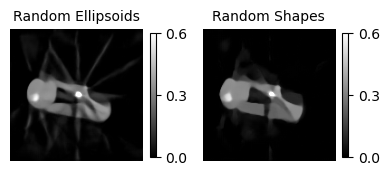

In [24]:
plot_images(
    [
        (Unet_ELL_mouse_slice.cpu().numpy(), "Random Ellipsoids", (0.0, 0.6)),
        (Unet_SHA_mouse_slice.cpu().numpy(), "Random Shapes", (0.0, 0.6)),
    ],
    n_col=2,
)

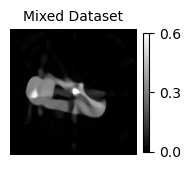

In [23]:
plot_images(
    [
        (Unet_MIX_mouse_slice.cpu().numpy(), "Mixed Dataset", (0.0, 0.6)),
    ],
    n_col=1,
)

## Mixed Loss Function

To allow a meaningful comparison between these two losses, the Mean Squared Error was scaled by a factor of 100, as it was consistently two orders of magnitude lower than the Dice Score upon convergence.


In [14]:
path = "outputs/_metricsDynamic/mse_dice.pkl"

with open(path, "rb") as f:
    data = pickle.load(f)

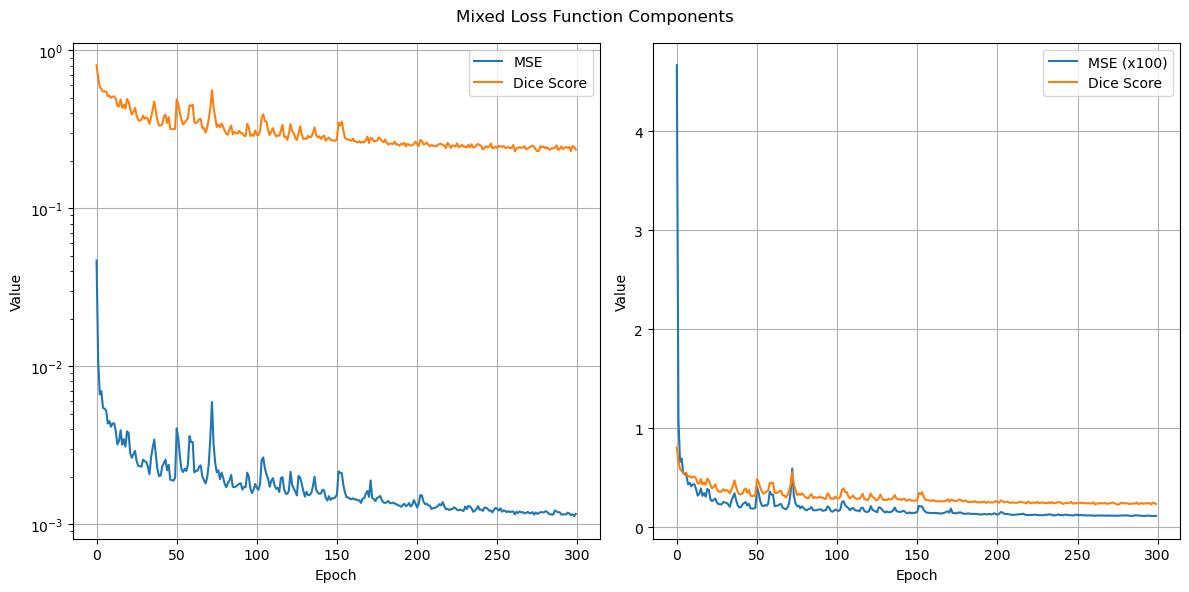

In [15]:
fig = plt.figure(figsize=(12, 6))

# First subplot
ax1 = fig.add_subplot(121)
ax1.plot(data["mse"], label="MSE")
ax1.plot(data["dice"], label="Dice Score")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Value")
ax1.set_yscale("log")
ax1.grid()
ax1.legend()

# Second subplot with MSE scaled to 100
ax2 = fig.add_subplot(122)
ax2.plot(np.array(data["mse"]) * 100, label="MSE (x100)")
ax2.plot(data["dice"], label="Dice Score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Value")
ax2.grid()
ax2.legend()

# Set fig title
fig.suptitle("Mixed Loss Function Components")
plt.tight_layout()

plt.show()